In [196]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

train = pd.read_csv("melting-point-data/train_newFeature.csv")

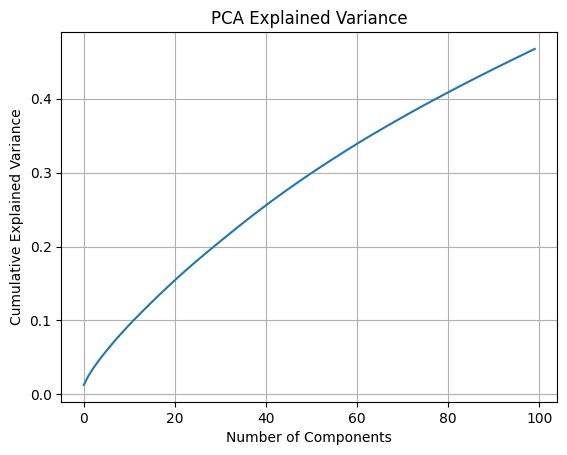

Index(['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6',
       'Group 7', 'Group 8', 'Group 9', 'Group 10',
       ...
       'Group 416', 'Group 417', 'Group 418', 'Group 419', 'Group 420',
       'Group 421', 'Group 422', 'Group 423', 'Group 424', 'MolWeight'],
      dtype='object', length=425)

In [197]:
#Principal Component Analysis
df = pd.read_csv("melting-point-data/train_newFeature.csv")

# Select numeric features (Groups + MolWeight)
num_cols = df.select_dtypes(include="number").columns
num_cols = num_cols.drop(["Unnamed: 0", "id", "Tm"])   # Target entfernen

X = df[num_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

# Variance explained
explained = pca.explained_variance_ratio_.cumsum()

plt.plot(explained)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

num_cols



In [198]:
#Daten vorbereiten

X_train = train.drop(["Tm", "SMILES", "Unnamed: 0", "id"], axis = 1)
X_train = np.array(X_train)

y_train = train["Tm"]
y_train = np.array(y_train)

#Daten skalieren
x_scale = StandardScaler()
y_scale = StandardScaler()

X_train = x_scale.fit_transform(X_train)
y_train = y_scale.fit_transform(y_train.reshape(-1,1))



In [199]:
#Modell aufbauen

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

num_features = X_pca.shape[1]

model = Sequential()
model.add(Dense(62, input_dim = num_features, activation = 'relu', kernel_regularizer=l2(0.001) ))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'sigmoid', kernel_regularizer=l2(0.001) ))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu', kernel_regularizer=l2(0.001) ))

model.add(Dense(1, activation = 'linear' ))


/Users/enricofritz/Documents/Meltingpoint_rep/Melting_point_project/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [200]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss = "mae", metrics=["mae"])
history = model.fit(X_pca,y_train, verbose = True, validation_split = 0.1, epochs = 250, callbacks=[callback])

Epoch 1/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9495 - mae: 0.7439 - val_loss: 0.8100 - val_mae: 0.6085
Epoch 2/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.8809 - mae: 0.6827 - val_loss: 0.7306 - val_mae: 0.5355
Epoch 3/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 0.8138 - mae: 0.6215 - val_loss: 0.6861 - val_mae: 0.4967
Epoch 4/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.7756 - mae: 0.5888 - val_loss: 0.6701 - val_mae: 0.4861
Epoch 5/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 0.7444 - mae: 0.5627 - val_loss: 0.6534 - val_mae: 0.4743
Epoch 6/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 0.7273 - mae: 0.5505 - val_loss: 0.6380 - val_mae: 0.4637
Epoch 7/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 0.7031 - mae: 0.5310 - val_loss: 0.6245 - val_mae: 0.4547
Epoch 8/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 0.6948 - mae: 0.5271 - val_loss: 0.6153 - val_mae: 0.4499
Epoch 9/250
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/st

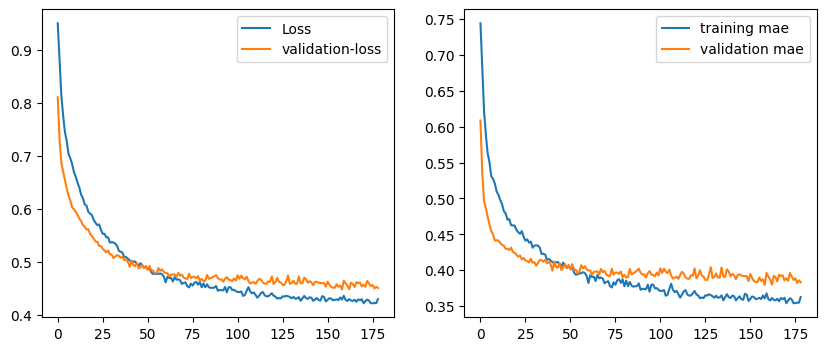

In [269]:
#plotting the results

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,4))

ax1.plot(history.history['loss'], label = "Loss")
ax1.plot(history.history['val_loss'], label = "validation-loss")

# ax1.plot(history.history['val_loss'])


ax2.plot(history.history['mae'], label= "training mae")
ax2.plot(history.history['val_mae'], label = "validation mae")

ax1.legend()
ax2.legend()



# ax2.plot(history.history['precision'])

In [202]:

model.evaluate(X_pca, y_train)

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.3760 - mae: 0.3089


[0.3759831190109253, 0.3089214265346527]

In [265]:
y_predict = y_scale.inverse_transform(model.predict(X_pca))
y_true = y_scale.inverse_transform(y_train)

mae = np.mean(np.abs(y_predict - y_true))

mae

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


np.float64(26.289805816375246)

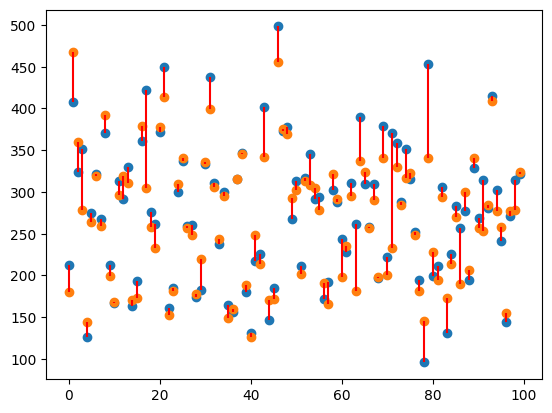

In [268]:
values = 100

x_axis = np.arange(0,2662,1)


plt.scatter(x_axis[:values], y_true[:values])
plt.scatter(x_axis[:values], y_predict[:values])

i = 0
while i < values:
    plt.vlines(x_axis[i], y_predict[i], y_true[i], color="red")
    i = i +1